In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import string as str
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [2]:
df = pd.read_csv('./data/social_leads_aug_sept_clean.csv')

/Users/joehardy/Dev/ML/ML_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (40,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Income
#Is U.S. Veteran
#Precise Age
#audience
#Landing URL
#creative
#Browser
#Android / iOS

In [4]:
def make_date_cols(df):
    df['lead_creation_datetime'] = pd.to_datetime(pd.Series(df['Lead Creation Datetime']))
    df['created_date'] = pd.to_datetime(pd.Series(df['Created Date']))
  #  df['datetime_of_first_call'] = pd.to_datetime(pd.Series(df['DateTime Of First Call']))
    df['converted_date'] = pd.to_datetime(pd.Series(df['Converted Date']))
    return(df)

In [5]:
df = make_date_cols(df)

In [6]:
df.columns

Index(['Lead Creation Datetime', 'Created Date', 'Lead ID', 'First Name',
       'Last Name', 'act', 'Customer browser language', 'Landing URL',
       'Browser', 'Android / iOS', 'User Device', 'Usage',
       'Controlling Channel', 'Marketing Partner', 'Marketing offer',
       'Lead Status', 'Reason for closing of lead', 'Converted',
       'Opportunity ID', 'Converted Date', 'Stage', 'Last quote',
       'Reason for closed and lost', 'Searching for', 'Experience',
       'Age of current hearing aid', 'Currently looking for hearing aids',
       'Visited ENT or audiologist', 'Recent hearing test', 'Why not sooner?',
       'COSI Basic Subtype 1', 'Discreet design', 'Tinnitus',
       'Purchase timeframe', 'Professional status', 'Income',
       'Income Reformatted', 'Willingness to invest', 'Is U.S. Veteran',
       'Exposed to loud noises', 'Mobile', 'Phone', 'Email', 'Precise Age',
       'Zip/Postal Code', 'Dynamic Marketing Comment', 'Video / Img',
       'audience', 'creative',

In [7]:
ct_conversions_income = pd.crosstab(index=df['Converted'], columns = [df['Income']])

In [8]:
ct_conversions_income

Income,"$30,000 ? $49,999","$30,000-$49,999","$50,000 ? $69,999","$50,000 to $69,999","$50,000-$69,999","$70,000 ? $89,999","$70,000-$89,999",Under 39 years-old,Unsure,"less than $30,000","more than $90,000"
Converted,,,,,,,,,,,
0,1672,18,2570,10,6,3185,10,1,21,2692,5595
1,127,2,224,0,0,318,2,0,0,169,521


In [9]:
ct_conversions_income.columns

Index(['$30,000 ? $49,999', '$30,000-$49,999', '$50,000 ? $69,999',
       '$50,000 to $69,999', '$50,000-$69,999', '$70,000 ? $89,999',
       '$70,000-$89,999', 'Under 39 years-old', 'Unsure', 'less than $30,000',
       'more than $90,000'],
      dtype='object', name='Income')

In [10]:
#less than $30,000	– Poor (0-639)
#$30,000 – $49,999	– Don't know
#$50,000 – $69,999	– Fair (640-679)
#$70,000 – $89,999	– Good (680-719)
#more than $90,000	– Excellent (720-850)

In [11]:
ct_conversions_credit = ct_conversions_income['$30,000 ? $49,999'] +   ct_conversions_income['$30,000-$49,999']

In [12]:
ct_conversions_income_rf = pd.crosstab(index=df['Converted'], columns = [df['Income Reformatted']])

In [13]:
ct_conversions_income_rf

Income Reformatted,"$30,000 - $49,999","$50,000 - $69,999","$70,000 - $89,999",< $30k,> $90k,Unsure
Converted,,,,,,
0,1690,2586,3195,2692,5595,22
1,129,224,320,169,521,0


In [14]:
ct_conversions_income_rf.columns

Index(['$30,000 - $49,999', '$50,000 - $69,999', '$70,000 - $89,999', '< $30k',
       '> $90k', 'Unsure'],
      dtype='object', name='Income Reformatted')

In [15]:
cr2_income = ct_conversions_income_rf.iloc[1] / ct_conversions_income_rf.iloc[0]


In [16]:
cr2_income

Income Reformatted
$30,000 - $49,999    0.076331
$50,000 - $69,999    0.086620
$70,000 - $89,999    0.100156
< $30k               0.062779
> $90k               0.093119
Unsure               0.000000
dtype: float64

In [17]:
income_credit = {"$30,000 - $49,999": "Don't know",
                 "Unsure": "Don't know",
                 "< $30k" : "Poor",
                 "$50,000 - $69,999": "Fair",
                 "$70,000 - $89,999": "Good",
                 "> $90k": "Excellent"}

In [18]:
df['Credit score'] = df['Income Reformatted'].map(income_credit)

In [19]:
# We might anticipate that not filling in the value for credit score
# would be more similar to entering "Don't know" than anything else.
# Last observation forward would also work, but might be difficult to implement in practice.
# Could also use NaN as a category -- pd.get_dummies(s1, dummy_na=True)
df['Credit score filled'] = df['Credit score'].fillna("Don't know")

In [20]:
ct_conversions_credit = pd.crosstab(index=df['Converted'], columns = [df['Credit score']])

In [21]:
ct_conversions_credit

Credit score,Don't know,Excellent,Fair,Good,Poor
Converted,,,,,
0,1712,5595,2586,3195,2692
1,129,521,224,320,169


In [22]:
cr2_credit = ct_conversions_credit.iloc[1] / ct_conversions_credit.iloc[0]

In [23]:
cr2_credit

Credit score
Don't know    0.075350
Excellent     0.093119
Fair          0.086620
Good          0.100156
Poor          0.062779
dtype: float64

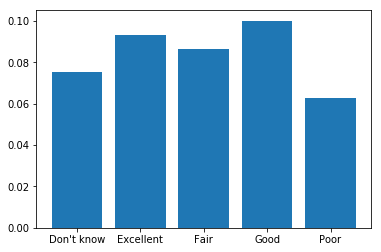

In [24]:
f = plt.bar(x=cr2_credit.index, height=cr2_credit.values)

In [25]:
cr2_credit_ri = cr2_credit.reindex(index = ["Don't know",'Poor','Fair','Good','Excellent'])

Text(0.5,0,'Credit score')

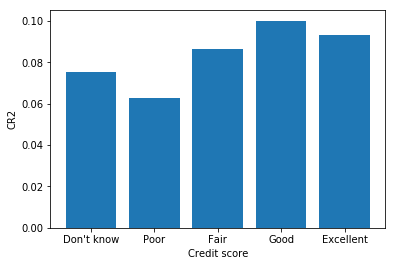

In [26]:
fig, ax = plt.subplots()
b = plt.bar(x=cr2_credit_ri.index, height=cr2_credit_ri.values)
ax.set_ylabel('CR2')
ax.set_xlabel('Credit score')

In [27]:
df['Numeric Age'] = pd.to_numeric(df['Precise Age'],errors='coerce')

In [28]:
df['Numeric Age'].mean()

67.12905295078143

In [29]:
df['Numeric Age Filled'] = df['Numeric Age'].fillna(method='ffill')

/Users/joehardy/Dev/ML/ML_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


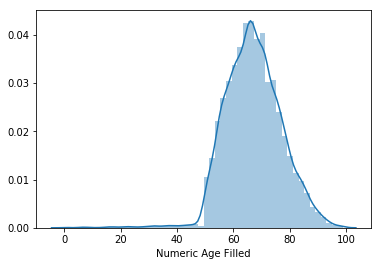

In [30]:
sns.distplot(df['Numeric Age Filled'])

In [31]:
df_age = df[(df['Numeric Age'] > 18) & (df['Numeric Age'] < 95)]

/Users/joehardy/Dev/ML/ML_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


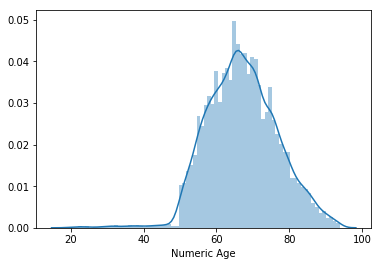

In [32]:
sns.distplot(df_age['Numeric Age'],bins = 76)

In [33]:
df_age.groupby('Converted').mean()

,Phone,Numeric Age,Numeric Age Filled
Converted,,,
0,1.629435e+10,67.309133,67.309133
1,1.629761e+10,65.336006,65.336006


/Users/joehardy/Dev/ML/ML_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


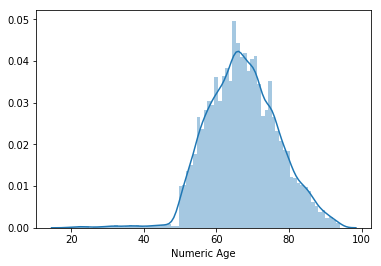

In [34]:
sns.distplot(df_age[df_age['Converted']==0]['Numeric Age'],bins = 76)

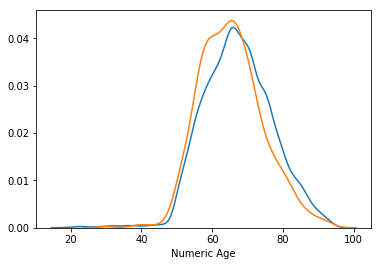

In [35]:
sns.distplot(df_age[df_age['Converted']==0]['Numeric Age'],bins = 76,hist=False)
sns.distplot(df_age[df_age['Converted']==1]['Numeric Age'],bins = 76,hist=False)

In [36]:
df['Numeric Age Filled'] 
df['Credit score filled']

0         Excellent
1              Good
2              Poor
3              Poor
4         Excellent
5              Good
6         Excellent
7              Good
8         Excellent
9              Fair
10             Good
11             Fair
12             Poor
13             Good
14        Excellent
15        Excellent
16             Poor
17             Fair
18       Don't know
19             Fair
20        Excellent
21       Don't know
22        Excellent
23        Excellent
24        Excellent
25             Good
26             Fair
27        Excellent
28             Good
29             Good
            ...    
17402          Fair
17403     Excellent
17404     Excellent
17405          Fair
17406          Poor
17407    Don't know
17408          Poor
17409    Don't know
17410          Fair
17411     Excellent
17412          Fair
17413     Excellent
17414          Poor
17415          Good
17416          Poor
17417    Don't know
17418          Good
17419     Excellent
17420          Poor


In [37]:
df_credit_dummies = pd.get_dummies(df['Credit score filled'], prefix='credit_')

In [38]:
converted = df["Converted"]

In [39]:
df = pd.concat([df,df_credit_dummies],axis=1)

In [40]:
df.columns

Index(['Lead Creation Datetime', 'Created Date', 'Lead ID', 'First Name',
       'Last Name', 'act', 'Customer browser language', 'Landing URL',
       'Browser', 'Android / iOS', 'User Device', 'Usage',
       'Controlling Channel', 'Marketing Partner', 'Marketing offer',
       'Lead Status', 'Reason for closing of lead', 'Converted',
       'Opportunity ID', 'Converted Date', 'Stage', 'Last quote',
       'Reason for closed and lost', 'Searching for', 'Experience',
       'Age of current hearing aid', 'Currently looking for hearing aids',
       'Visited ENT or audiologist', 'Recent hearing test', 'Why not sooner?',
       'COSI Basic Subtype 1', 'Discreet design', 'Tinnitus',
       'Purchase timeframe', 'Professional status', 'Income',
       'Income Reformatted', 'Willingness to invest', 'Is U.S. Veteran',
       'Exposed to loud noises', 'Mobile', 'Phone', 'Email', 'Precise Age',
       'Zip/Postal Code', 'Dynamic Marketing Comment', 'Video / Img',
       'audience', 'creative',

In [41]:
model_columns = ["credit__Don't know", 'credit__Poor', 'credit__Excellent',
                 'credit__Fair', 'credit__Good','Numeric Age Filled']

In [42]:
df_model_data = df[model_columns]

In [43]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

NameError: name 'y' is not defined